### Convolutional Autoencoder for Noise Removal

#### TF-Keras

#### Dataset - Mnist

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

from tqdm import tqdm

np.random.seed(1337)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##### Load Dataset

In [2]:
# load MNIST dataset
(X_train, _), (X_test, _) = mnist.load_data()

In [3]:
# info about the train and test sets
print(f'Shape X_train: {X_train.shape}, Min: {np.min(X_train)}, Max: {np.max(X_train)}, type: {type(X_train)}, dtype: {X_test.dtype}')
print(f'Shape X_test: {X_test.shape}, Min: {np.min(X_test)}, Max: {np.max(X_test)}, type: {type(X_test)}, dtype: {X_test.dtype}')

Shape X_train: (60000, 28, 28), Min: 0, Max: 255, type: <class 'numpy.ndarray'>, dtype: uint8
Shape X_test: (10000, 28, 28), Min: 0, Max: 255, type: <class 'numpy.ndarray'>, dtype: uint8


In [4]:
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

X_train = np.expand_dims(X_train, axis=3)
X_test  = np.expand_dims(X_test, axis=3)

image_size = X_train.shape[1]

print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


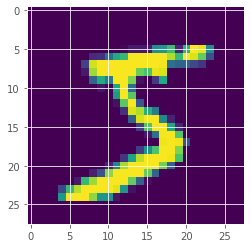

In [5]:
plt.imshow(X_train[0])

##### Generating Noise

In [6]:
# Adding noise
factor = 0.5
X_train_noise = X_train + factor * np.random.normal(loc=0, scale=1, size=X_train.shape)
X_test_noise = X_test + factor * np.random.normal(loc=0, scale=1, size=X_test.shape)

# Cliping
X_train_noise = np.clip(X_train_noise, a_min=0, a_max=1)
X_test_noise = np.clip(X_test_noise, a_min=0, a_max=1)

# Shape and range
print()
print(' >> X_train_noise:')
print(f'    Shape:    {X_train_noise.shape}')
print(f'    Range:    [{X_train_noise.min()}, {X_train_noise.max()}]')
print()
print(' >> X_test_noise:')
print(f'    Shape:    {X_test_noise.shape}')
print(f'    Range:    [{X_test_noise.min()}, {X_test_noise.max()}]')
print()


 >> X_train_noise:
    Shape:    (60000, 28, 28, 1)
    Range:    [0.0, 1.0]

 >> X_test_noise:
    Shape:    (10000, 28, 28, 1)
    Range:    [0.0, 1.0]



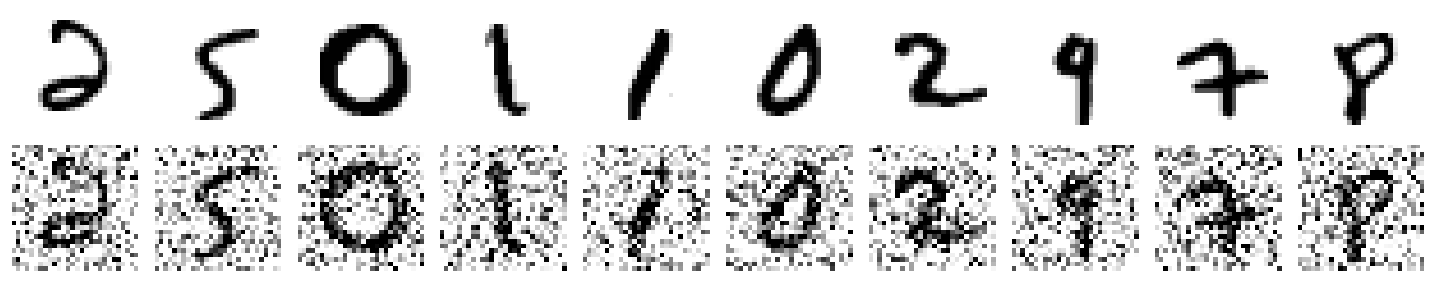

In [7]:
num_imgs = 10
idxs = np.random.randint(low=0, high=len(X_train), size=num_imgs)

plt.figure(figsize=(20, 4))

for i, idx in enumerate(idxs):
    
    # Originals
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[idx].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    
    # Noisy
    plt.subplot(2, 10, i+1 + num_imgs)
    plt.imshow(X_train_noise[idx].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

##### Model Architecture

In [8]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
______________________________________

In [9]:
opt = Adam(learning_rate=1e-2)

autoencoder.compile(
    loss='mse',
    optimizer=opt,
)

#### Training

In [10]:
epochs = 100
batch = 256

# early stopping
es = EarlyStopping(
    monitor='val_loss',
    patience=int(0.25*epochs),
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=True,
)

# ReduceLROnPlateau
red_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=15,
    factor=0.9,
    min_lr=1e-5,
    verbose=True,
)

# fit do modelo
hist = autoencoder.fit(
    x=X_train_noise, y=X_train,
    batch_size=batch,
    epochs=epochs,
    validation_data=(X_test_noise, X_test),
    callbacks=[es, red_lr],
)

Epoch 1/100
235/235 [==============================] - 8s 20ms/step - loss: 0.0887 - val_loss: 0.0875 - lr: 0.0100
Epoch 2/100
235/235 [==============================] - 4s 18ms/step - loss: 0.0835 - val_loss: 0.0624 - lr: 0.0100
Epoch 3/100
235/235 [==============================] - 4s 17ms/step - loss: 0.0323 - val_loss: 0.0218 - lr: 0.0100
Epoch 4/100
235/235 [==============================] - 4s 16ms/step - loss: 0.0205 - val_loss: 0.0191 - lr: 0.0100
Epoch 5/100
235/235 [==============================] - 4s 17ms/step - loss: 0.0186 - val_loss: 0.0177 - lr: 0.0100
Epoch 6/100
235/235 [==============================] - 4s 17ms/step - loss: 0.0175 - val_loss: 0.0171 - lr: 0.0100
Epoch 7/100
235/235 [==============================] - 4s 17ms/step - loss: 0.0169 - val_loss: 0.0169 - lr: 0.0100
Epoch 8/100
235/235 [==============================] - 4s 17ms/step - loss: 0.0165 - val_loss: 0.0165 - lr: 0.0100
Epoch 9/100
235/235 [==============================] - 4s 17ms/step - loss: 0.01

#### Loss Function Curves

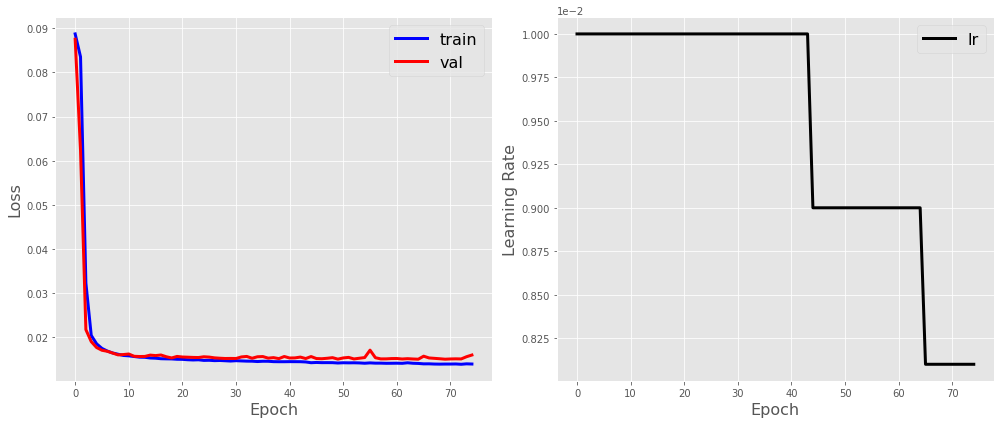

In [11]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(hist.history['loss'], label='train', c='b', linewidth=3)
plt.plot(hist.history['val_loss'], label='val', c='r', linewidth=3)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)

plt.subplot(122)
plt.plot(hist.history['lr'], label='lr', c='k', linewidth=3)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Learning Rate', fontsize=16)
plt.legend(fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.grid(True)

plt.tight_layout()
plt.show()

#### Plot results

 * Original image
 * Noisy image
 * Latent vector
 * Reconstructed image


In [12]:
coded_imgs = encoder.predict(X_test_noise)

decoded_imgs= decoder.predict(coded_imgs)

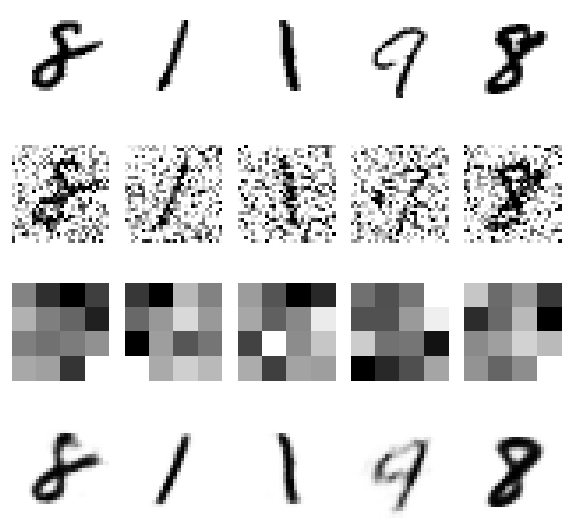

In [13]:
num_imgs = 5
idxs = np.random.randint(low=0, high=len(X_test), size=num_imgs)

plt.figure(figsize=(8, 8))

for i, idx in enumerate(idxs):
  # Originais
  plt.subplot(4, 5, i+1)
  plt.imshow(np.reshape(X_test[idx], (28, 28)), cmap='gray_r')
  plt.xticks([])
  plt.yticks([])

  # Com ruido
  plt.subplot(4, 5, i+1 + 1*num_imgs)
  plt.imshow(np.reshape(X_test_noise[idx], (28, 28)), cmap='gray_r')
  plt.xticks([])
  plt.yticks([])

  #Latente
  plt.subplot(4, 5, i+1 + 2*num_imgs)
  plt.imshow(np.reshape(coded_imgs[idx], (4, 4)), cmap='gray_r')
  plt.xticks([])
  plt.yticks([])

  # Reconstruidas
  plt.subplot(4, 5, i+1 + 3*num_imgs)
  plt.imshow(np.reshape(decoded_imgs[idx], (28, 28)), cmap='gray_r')
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.show()

#### Quantitative evaluation using SNR

In [14]:
def snr_db(im_original, im_reconstructed):
    """
    Calcula a SNR, em dB, de uma reconstrução.
    
    Parâmetros:
        im_original : Numpy.Array
            Matriz da imagem original, com shape (H, W, C)

        im_reconstructed : Numpy.Array
            Matriz da imagem reconstruída, com shape (H, W, C)
            
    Retorno:
        snr : float
            SNR calculada em dB.
    """
    import numpy as np
    orig_sum = np.sum(im_original)
    error_sum = np.abs(np.sum(im_original - im_reconstructed))
    snr = 20 * np.log10(orig_sum/error_sum)
    return snr

In [15]:
snr_vector = []
for orig, recons in zip(X_test, decoded_imgs):
    snr = snr_db(orig, recons)
    snr_vector.append(snr)

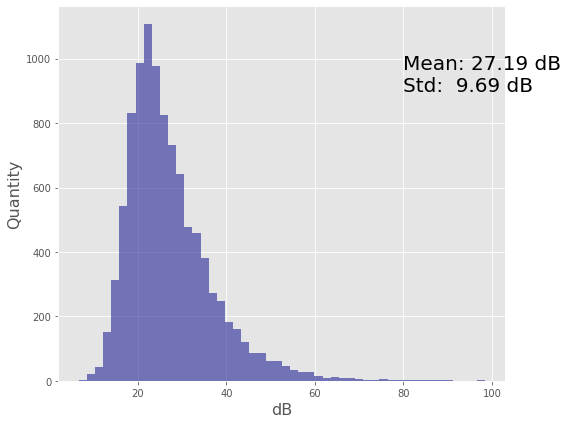

In [16]:
#plot snr hist
snr_mean = np.mean(snr_vector)
snr_std  = np.std(snr_vector)

plt.figure(figsize=(8, 6))

plt.hist(snr_vector, bins=50, color='darkblue', alpha=0.5)
plt.text(x=80, y=900, s=f'Mean: {snr_mean:.2f} dB\nStd:  {snr_std:.2f} dB', fontsize=20)
plt.ylabel('Quantity', fontsize=16)
plt.xlabel('dB', fontsize=16)

plt.grid(True)

plt.tight_layout()
plt.show()